#### Installing requirements

In [ ]:
#installation of tree Visualization package
os.system("pip install ete3 pyqt5 six lxml")
os.environ['QT_QPA_PLATFORM']='offscreen'

In [ ]:
%%capture
import sys
# installation of GOT (G eneralization O ver T axonomies) software package
!mkdir /content/gotlib
if not os.listdir('/content/gotlib'):
  !git clone https://github.com/dmitsf/GOT.git /content/gotlib
sys.path.append('/content/gotlib')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading taxonomies
%%capture
!cp /content/drive/MyDrive/arxiv_category_taxonomy.csv arxiv_category_taxonomy.csv 

!python3 /content/gotlib/got/taxonomies/taxonomy.py arxiv_category_taxonomy.csv 

#### Lapin and Faddis

All that has changed is the use of a more accurate function `np.linalg.eigh()` for symmetric matrices instead of the function `np.linalg.eig()`.  
The Lapin function began to give a more accurate answer: for two matrices that are close in value (the modulus of the elementwise difference does not exceed 1e-12), the result is also close (the modulus of the elementwise difference does not exceed 1e-12). What was wrong with the original version.  
The Faddis function still produces different responses to input matrices that are close in value (with the same accuracy of 1e-12).

In [ ]:
import numpy.linalg as LA

ZERO_BOUND = 10 ** (-8)
ENTITY_BOUND = 10 ** (-4)


def lapin64(A):
    '''
    '''
    A = (A + A.T) / 2
    a_sums = np.ravel(abs(sum(A)))
    
    checked = np.array(a_sums > ENTITY_BOUND)
    is_correct = checked.all()

    if not is_correct:
        print('These entities are no good - remove them first!!!')
        print([i for i, j in enumerate(checked, 1) if not j])
        A = A[:, checked][checked, :]
        a_sums = a_sums[checked]

    matrix_dim, _ = A.shape
    C = np.empty((matrix_dim, matrix_dim), dtype=np.float64)
    for i in range(matrix_dim):
        for j in range(matrix_dim):
            C[i, j] = A[i, j] / np.sqrt(a_sums[i] * a_sums[j])

    eig_vals, eig_vecs = LA.eigh(np.eye(matrix_dim, dtype=np.float64) - C) # use eigh instead of eig
    eig_vals_diag = np.diag(eig_vals)
    nonzero_cond = np.array(eig_vals > ZERO_BOUND)
    nonzero_eig_vals_diag = eig_vals_diag[nonzero_cond, :][:, nonzero_cond]
    nonzero_eig_vecs = eig_vecs[:, nonzero_cond]
    B = nonzero_eig_vecs.dot(LA.inv(nonzero_eig_vals_diag)).dot(nonzero_eig_vecs.T)

    return B


''' FADDIS clustering implementation in Python
'''

import numpy as np
import numpy.linalg as LA

ZERO_BOUND_F = 10 ** (-9)
MIN_CLUSTER_CONTRIBUTION = 5 * 10 ** (-3)
EPSILON = 5 * 10 ** (-2)
# Maximum number of clusters
MAX_NUM_CLUSTERS = 15


def ensure_np_matrix(A):

    if not isinstance(A, np.matrix):
        A = np.matrix(A)
    return A


def faddis64(A):
    ''' faddis: equential extraction of fuzzy clusters, in a sequential manner
    A is NxN similatriy matrix, symmetrized
    membership_matrix - NxK membership matix of clustering;
    contrib - 1xK vector of relative contributions to the data scatter;
    intensity - Kx2 matrix of cluster intensities^0.5 and intensities;
    lat - 1xK vector of eigen-values corresponding to clusters;
    cluster_got
    '''
    A = ensure_np_matrix(A).astype('float64')
    
    # minimum cluster's relative contribution to the data scatter
    min_cont = MIN_CLUSTER_CONTRIBUTION
    # minimum relative residual data scatter
    eps = EPSILON
    # maximum number of clusters
    max_clust_num = MAX_NUM_CLUSTERS

    is_positive = True
    matrix_dim, _ = A.shape

    sc = np.power(A, 2)
    # Total data scatter
    scatter = np.sum(sc)

    cluster_got = 0
    membership_matrix = np.empty((matrix_dim, 0))
    contrib = np.array([])
    lat = np.array([])
    intensities = np.empty((0, 2))
    curr_cont = 1
    res_cont = 1

    # 'zero' and 'one' vectors for comparisons
    zeros_vect = np.zeros((matrix_dim, 1))
    ones_vect = np.ones((matrix_dim, 1))

    # ensure matrix is symmetrical
    At = (A + A.T) / 2
    matrix_sequence = [At]


    # Stop condition:
    # is_positive is True: eigen-value of the residual matrix is not positive;
    # OR la cluster intensity  reaches its minimum lam;
    # OR ep relative residual data scatter reaches its minimum eps;
    # OR maximum number of clusters max_clust_num is achieved
    while is_positive and curr_cont > min_cont and res_cont > eps and cluster_got <= max_clust_num:
        # collecting a fuzzy cluster membership uf, with contrib con and intensity la,
        eig_vals, eig_vecs = LA.eigh(At) # use eigh enstead of eig
 
        # (lt, ii) - (maximum eigen-value, corresponding position)
        eig_vals_diag = np.diag(eig_vals)
        # Only positive eigenvalues
        eig_vals_pos = np.argwhere(eig_vals > ZERO_BOUND_F).ravel()
        eig_vals_pos_len = eig_vals_pos.size
        cur_intensities = np.zeros((eig_vals_pos_len, 1), dtype=np.float64)
        vm = np.zeros((matrix_dim, eig_vals_pos_len))
        
        for k in range(eig_vals_pos_len):
            lt = eig_vals_diag[eig_vals_pos[k]]
            vf = eig_vecs[:, eig_vals_pos[k]]

            # Calculate normalized membership vector belonging to [0, 1] by
            # projection on the space. The normalization factor is the
            # Euclidean length of the vector
            bf = np.maximum(zeros_vect, vf)
            uf = np.minimum(bf, ones_vect)
            
            if LA.norm(uf) > 0:
                uf = uf / LA.norm(uf)

            vt = uf.T.dot(At).dot(uf)
            uf = np.squeeze(np.asarray(uf))

            wt = uf.T.dot(uf)
            # Calculates the intensity Lambda (la) of the cluster, which is
            # defined almost as the Rayleigh quotient
            if wt > 0:
                la = vt.item() / (wt **2)
            else:
                la = 0

            # since lt*vf =(-lt)*(-vf), try symmetric version 
            # using -vf:
            vf1 = -vf

            bf1 = np.maximum(zeros_vect, vf1)
            uf1 = np.minimum(bf1, ones_vect)
            uf1 = np.squeeze(np.asarray(uf1))

            if LA.norm(uf1) > 0:
                uf1 = uf1 / LA.norm(uf1)
                
            vt1 = uf1.T.dot(At).dot(uf1)
            wt1 = uf1.T.dot(uf1)
            if wt1 > 0:
                la1 = vt1.item() / (wt1 **2)
            else:
                la1 = 0

            if la > la1:
                cur_intensities[k] = la
                vm[:, k] = uf.ravel()
            else:
                cur_intensities[k] = la1
                vm[:, k] = uf1.ravel()

        contrib_max, contrib_max_index = cur_intensities.max(), cur_intensities.argmax()
        if contrib_max > ZERO_BOUND_F:
            lat = np.append(lat, eig_vals[eig_vals_pos[contrib_max_index]])
            intensities = np.append(intensities, np.matrix([np.sqrt(contrib_max),
                                                            contrib_max]), axis=0)
            # square root and value of lambda intensity of cluster_got
            # square root shows the value of fuzzyness
            uf = vm[:, contrib_max_index]
            vt = uf.T.dot(At).dot(uf)
            wt = uf.T.dot(uf)

            membership_matrix = np.append(membership_matrix, np.matrix(uf).T, axis=1)
            # calculate residual similarity matrix:
            # remove the present cluster (i.e. itensity* membership) from
            # similarity matrix
            Att = At - contrib_max * np.matrix(uf).T * np.matrix(uf)
            At = (Att + Att.T) / 2
            matrix_sequence.append(At)

            curr_cont = (vt / wt) ** 2
            # Calculate the relative contribution of cluster_got
            curr_cont /= scatter
            contrib = np.append(contrib, curr_cont)
            # Calculate the residual contribution
            res_cont -= curr_cont
            cluster_got += 1
        else:
            is_positive = False

    if not is_positive:
        print('No positive weights at spectral clusters')
    elif curr_cont < min_cont:
        print('Cluster contribution is too small')
    elif res_cont < eps:
        print('Residual is too small')
    elif cluster_got > max_clust_num:
        print('Maximum number of clusters reached')

    return matrix_sequence, membership_matrix, contrib, intensities, lat, cluster_got

#### Data preparation

In [ ]:
import numpy as np
from numba import guvectorize, vectorize
from numba import cuda

In [ ]:
#from got.relevance_analysis.lapin import lapin
#from got.relevance_analysis.faddis import faddis

from operator import itemgetter

NUM_EL = 15

relevance_matrix = np.loadtxt("/content/drive/MyDrive/relevance_matrix_range_0k-1000k.txt")
print(relevance_matrix.shape)

(1000000, 155)


In [ ]:
rel_mat = relevance_matrix.astype('float64')

In [ ]:
tc = rel_mat.T.dot(rel_mat)

/usr/local/lib/python3.9/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
print(tc.shape)

tc_transformed = lapin64(tc)
B, member, contrib, intensity, lat, tt = faddis64(tc_transformed)
np.savetxt("clusters.dat", member)

with open("taxonomy_leaves.txt") as fn:
    annotations = [l.strip() for l in fn]

for cluster in member.T:
    print(list(sorted(zip(annotations, cluster.flat),
                      key=itemgetter(1), reverse=True))[:NUM_EL])

(155, 155)
Cluster contribution is too small
[('mathematical finance', 0.8586283894208455), ('general physics', 0.5090070058390059), ('computational physics', 0.06057036091020725), ('general economics', 0.0004360344015557236), ('statistics and probability', 0.0002723510478221879), ('classical physics', 0.00017464207665101315), ('analysis of pdes', 0.00015326581333242512), ('medical physics', 0.00012540826873478524), ('general topology', 0.0001008244530140204), ('algebraic geometry', 9.021075491350373e-05), ('biological physics', 8.506798586973325e-05), ('computer science and game theory', 6.652553647588447e-05), ('computational complexity', 6.577243010778959e-05), ('other condensed matter', 6.536688177784925e-05), ('data structures and algorithms', 5.510195785106382e-05)]
[('machine learning', 0.841506652685188), ('numerical analysis', 0.4568035322455715), ('systems and control', 0.2381542887060966), ('statistics theory', 0.150174290758162), ('mathematical physics', 0.06001076131756257

In [ ]:
for cluster in member.T:
    cl = list(sorted(zip(annotations, cluster.flat),
                      key=itemgetter(1), reverse=True))[:NUM_EL]
    cl = [word[0] for word in cl]
    print(cl)

['mathematical finance', 'general physics', 'computational physics', 'general economics', 'statistics and probability', 'classical physics', 'analysis of pdes', 'medical physics', 'general topology', 'algebraic geometry', 'biological physics', 'computer science and game theory', 'computational complexity', 'other condensed matter', 'data structures and algorithms']
['machine learning', 'numerical analysis', 'systems and control', 'statistics theory', 'mathematical physics', 'information theory', 'computational finance', 'general physics', 'computational geometry', 'algebraic topology', 'economics', 'soft condensed matter', 'high energy physics - theory', 'statistics and probability', 'other quantitative biology']
['high energy physics - experiment', 'nuclear theory', 'k-theory and homology', 'general economics', 'high energy astrophysical phenomena', 'general finance', 'quantitative methods', 'other computer science', 'classical analysis and odes', 'algebraic topology', 'mathematical s

#### Cluster Analisys

In [ ]:
!python3 /content/gotlib/got/taxonomies/pargenfs.py arxiv_category_taxonomy.csv taxonomy_leaves.txt clusters.dat 0

Number of leaves: 155
All positive weights:
mathematical finance                                         0.85863
general physics                                              0.50901
computational physics                                        0.06057
general economics                                            0.00044
classical physics                                            0.00017
analysis of pdes                                             0.00015
medical physics                                              0.00013
general topology                                             0.00010
algebraic geometry                                           0.00009
biological physics                                           0.00009
computer science and game theory                             0.00007
computational complexity                                     0.00007
other condensed matter                                       0.00007
data structures and algorithms                             

##### Visualization treestyle

In [ ]:
from ete3 import TextFace, Tree, TreeStyle, \
    NodeStyle, RectFace, PieChartFace, TreeNode
from got.taxonomies.visualize import layout_lift, read_ete3_from_file


ts = TreeStyle()
ts.show_leaf_name = False
ts.layout_fn = layout_lift

ts.rotation = 90
ts.branch_vertical_margin = 10
ts.show_scale = False
ts.scale = 50
ts.title.add_face(TextFace(" ", fsize=20), column=0)

ts.legend.add_face(TextFace("  "), column=0)
ts.legend.add_face(TextFace("  "), column=1)
ts.legend.add_face(TextFace("  "), column=2)
ts.legend.add_face(TextFace("  "), column=3)

ts.legend.add_face(TextFace("              "), column=0)
ts.legend.add_face(TextFace("Node shape and size:"), column=1)
ts.legend.add_face(TextFace("              "), column=2)
ts.legend.add_face(TextFace("Node color - membership value:"), column=3)

ts.legend.add_face(TextFace("  "), column=0)
ts.legend.add_face(TextFace("  "), column=1)
ts.legend.add_face(TextFace("  "), column=2)
ts.legend.add_face(TextFace("  "), column=3)

ts.legend.add_face(PieChartFace([100], 20, 20, colors=['white'], line_color='black'), column=0)
ts.legend.add_face(TextFace("  topic that relates to the cluster"), column=1)

ts.legend.add_face(RectFace(30, 10, "#90ee90", "#90ee90"), column=2)
ts.legend.add_face(TextFace("  topic with minor membership 0<u(t)<=0.2"), column=3)

ts.legend.add_face(TextFace("  "), column=0)
ts.legend.add_face(TextFace("  "), column=1)
ts.legend.add_face(TextFace("  "), column=2)
ts.legend.add_face(TextFace("  "), column=3)

ts.legend.add_face(PieChartFace([100], 40, 40, colors=['white'], line_color='black'), column=0)
ts.legend.add_face(TextFace("  head subject"), column=1)

ts.legend.add_face(RectFace(30, 10, "green", "green"), column=2)
ts.legend.add_face(TextFace(u"  topic with medium membership 0.2<u(t)<=0.4   "), column=3)

ts.legend.add_face(TextFace("  "), column=0)
ts.legend.add_face(TextFace("  "), column=1)
ts.legend.add_face(TextFace("  "), column=2)
ts.legend.add_face(TextFace("  "), column=3)

ts.legend.add_face(RectFace(20, 20, "black", "white"), column=0)
ts.legend.add_face(TextFace("  topic that doesn't relate to cluster                     "), \
                    column=1)

ts.legend.add_face(RectFace(30, 10, "#004000", "#004000"), column=2)
ts.legend.add_face(TextFace("  topic with high membership u(t)>0.4"), column=3)

ts.legend.add_face(TextFace("  "), column=0)
ts.legend.add_face(TextFace("  "), column=1)
ts.legend.add_face(TextFace("  "), column=2)
ts.legend.add_face(TextFace("  "), column=3)

ts.legend.add_face(TextFace("  "), column=1)
ts.legend.add_face(TextFace("  "), column=1)

ts.legend.add_face(RectFace(30, 10, "red", "red"), column=2)
ts.legend.add_face(TextFace("  topic with no membership (u(t)=0)"), column=3)

ts.legend_position = 3

##### Visualization

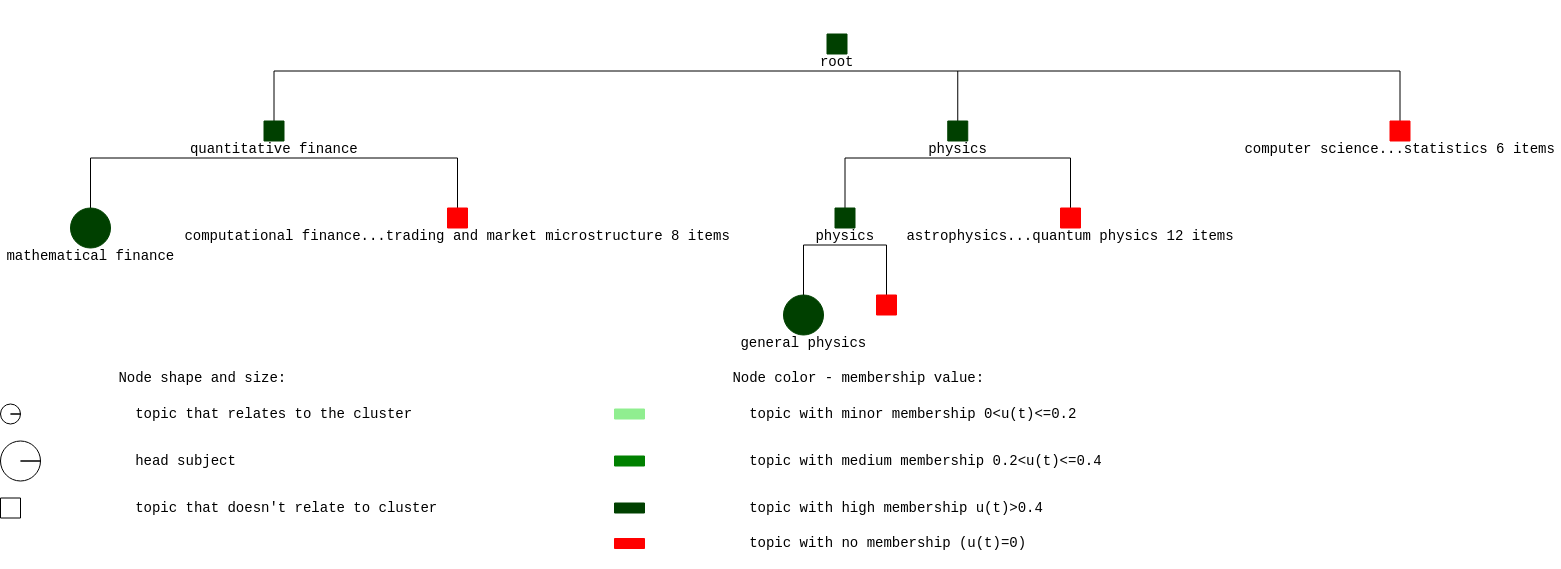

In [ ]:
filename = '/content/taxonomy_tree_lifted.ete'

ete3_desc = read_ete3_from_file(filename)
tree = Tree(ete3_desc, format=1)

tree.render("%%inline", tree_style=ts)